# Testing new utility function for MPO

Data imports.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Instantiate designer.

In [2]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Instantiate Oracles.

In [3]:
from dgym.envs.utility import PenaltyUtilityFunction

docking_utility_function = PenaltyUtilityFunction(
    ideal=(8, float('inf')),
    acceptable=(7.5, float('inf'))
)

log_P_utility_function = PenaltyUtilityFunction(
    ideal=(1, 3),
    acceptable=(-0.5, 4.5)
)

log_S_utility_function = PenaltyUtilityFunction(
    ideal=(-2, 1),
    acceptable=(-4, 0)
)

Text(0.5, 1.0, 'Utility function for multi-objective')

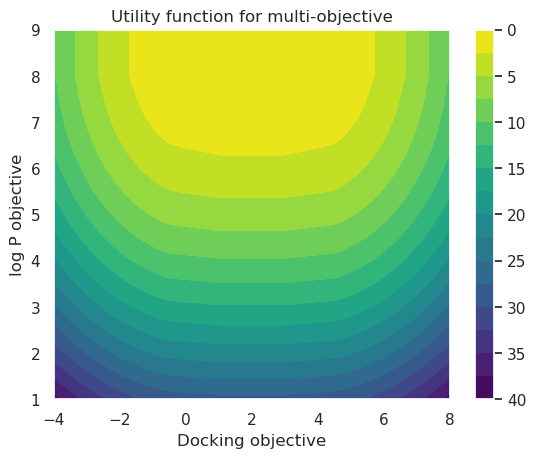

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
# log_P_scores = np.random.uniform(-3, 8, 100)
# docking_scores = np.random.uniform(4, 9, 100)
log_P_scores = np.linspace(-4, 8, 100)
docking_scores = np.linspace(1, 9, 100)

log_P_utility = log_P_utility_function(log_P_scores)
docking_utility = docking_utility_function(docking_scores)

plt.xlabel('Docking objective')
plt.ylabel('log P objective')

X, Y = np.meshgrid(log_P_scores, docking_scores)
Z = np.mean([log_P_utility_function(X.ravel()), docking_utility_function(Y.ravel())], axis=0)
Z = Z.reshape(100, 100)
contour = plt.contourf(X, Y, Z, levels=18, cmap="viridis_r")
plt.plot()
bar = plt.colorbar(contour)
bar.ax.invert_yaxis()
plt.title('Utility function for multi-objective')

## Pareto-sorting / non-dominated sorting

In [29]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# log_S_scores = np.random.uniform(-6, 2, 100)
log_P_scores = np.random.uniform(-4, 8, 1_000)
docking_scores = np.random.uniform(4, 9.5, 1_000)

scores = np.array([
    # log_S_scores,
    log_P_scores,
    docking_scores
]).T

# transform scores
utilities = [
    # log_S_utility_function(log_S_scores),
    log_P_utility_function(log_P_scores),
    docking_utility_function(docking_scores)
]

utilities = np.vstack(utilities).T

# perform sort
nds = NonDominatedSorting().do(utilities, only_non_dominated_front=False)

In [8]:
# sns.scatterplot(x=np.round(utilities, 1)[:,1], y=np.round(utilities, 1)[:,2])

In [30]:
import pandas as pd

records = []
for idx, front in enumerate(nds):
    for jdx in front:
        score = scores[jdx]
        records.append({
            # 'log S': score[0],
            'log P': score[0],
            'potency': score[1],
            'front': idx,
        })
        
df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


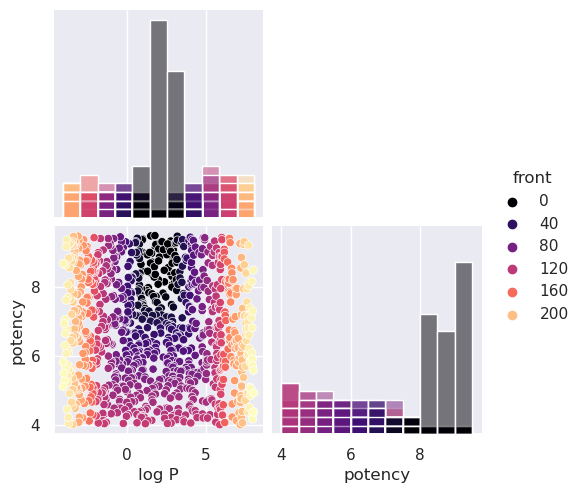

In [31]:
sns.pairplot(df, hue='front', palette='magma', corner=True, diag_kind='hist')

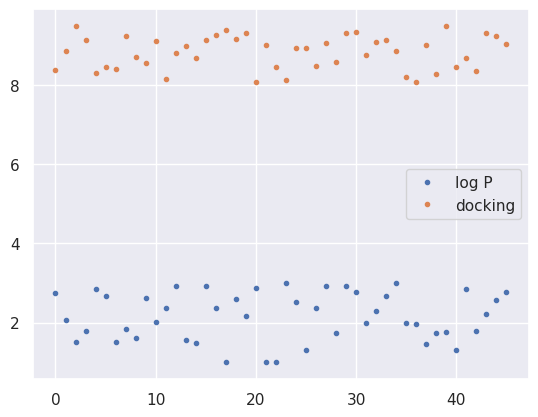

In [38]:
plt.plot(scores[nds[0]], '.')
plt.legend(['log P', 'docking'])